# EECS731
## Project 6 - D(St)reams of Anomalies

The real world does not slow down for bad data
1.  Set up a data science project structure in a new git repository in your GitHub account
2.  Download the benchmark data set from
https://www.kaggle.com/boltzmannbrain/nab  or
https://github.com/numenta/NAB/tree/master/data
3.  Load the  one  of the data set into panda data frames
4.  Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5.  Build one or more anomaly detection models to determine the  anomalies  using the other columns as features
6.  Document your process and results
7.  Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

<br>
***

In [1]:
from pandas import read_csv, Series, DataFrame, to_datetime, to_timedelta, concat, isnull, DatetimeIndex
from numpy import isnan, any, all, isfinite, where, column_stack,ravel, vstack, \
    sum, sqrt, int64, outer, argmax, matlib, linalg, array
from itertools import product

# Feature engineering and selection
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.decomposition import PCA

# models
from fbprophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings('ignore')

# plots
from matplotlib.pyplot import figure , imshow, axis, show, plot, subplots, title, xlabel, ylabel, legend, gca
from matplotlib.patches import Patch
from seaborn import heatmap

Importing plotly failed. Interactive plots will not work.


In [2]:
df = read_csv("../data/raw/nyc_taxi.csv")
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [4]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

## Let's look deeper at the datasets given

Column | Definition
-----| ---------
timestamp | date and time yyyy-mm-dd
value | amount of people looking for taxi

<br>

Looking at the above information:
- No null data
- change date to timestamp column 
<br>

# Let's start data cleaning
***
***Change timestamp to datetime type***

In [5]:
df["timestamp"] = to_datetime(df["timestamp"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


# Plotting the data

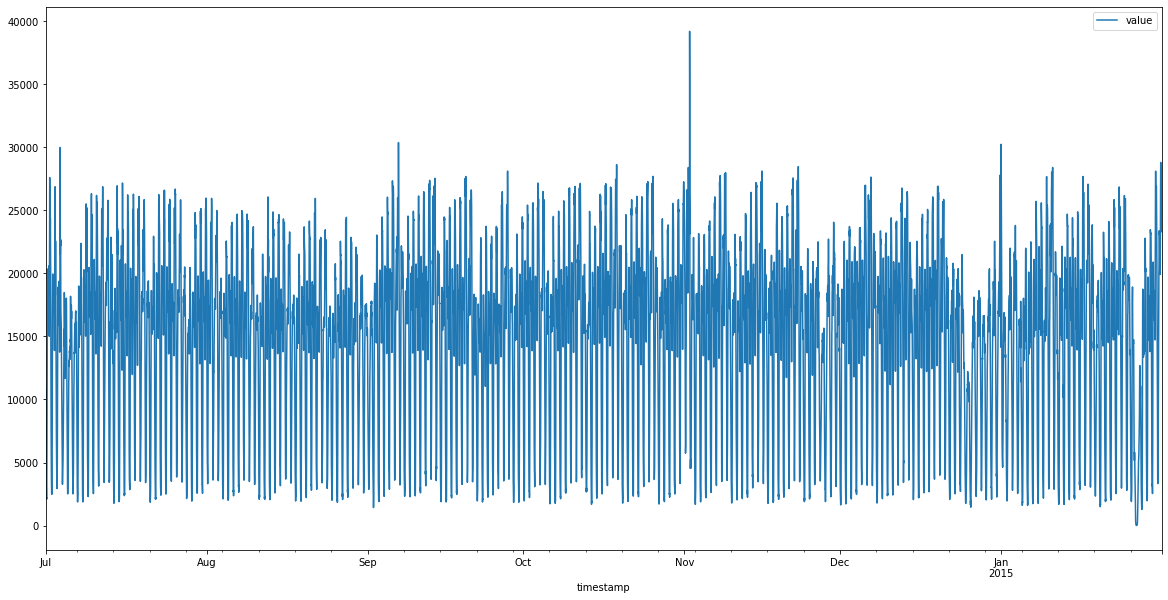

In [6]:
figure(figsize=(20,10))
df.plot(x="timestamp",y="value", ax=gca())
show()

***Add a new columns "seconds" which is timestamp to seconds***

In [7]:
df["seconds"] =  (df['timestamp'].astype(int64)/100000000000).astype(int64)
df.head()

,timestamp,value,seconds
0,2014-07-01 00:00:00,10844,14041728
1,2014-07-01 00:30:00,8127,14041746
2,2014-07-01 01:00:00,6210,14041764
3,2014-07-01 01:30:00,4656,14041782
4,2014-07-01 02:00:00,3820,14041800


***Standardize the data***

In [8]:
X = df[["seconds","value"]]
np_scaled = StandardScaler().fit_transform(X)
X = DataFrame(np_scaled)
X.head()

,0,1
0,-1.731883,-0.618745
1,-1.731547,-1.010291
2,-1.731212,-1.286549
3,-1.730876,-1.510496
4,-1.730540,-1.630971


***
# KMeans 
***A function to find the KMean's elbow curve index***

In [9]:
def get_elbow_curve(y_axis_list):
    # get the list of coordinates
    num_points = len(y_axis_list)
    # add index to the errors by combining them [ [range(0,19)], [Errors] ]
    all_coords = vstack((range(num_points), y_axis_list))
    # Tranform into [ [0, Errors[0], [..,..]]]
    all_coords = all_coords.T

    #get the vector line that we will be comparing to
    vector = all_coords[-1] - all_coords[0]
    # Eculidian Norm 
    vector_norm = vector / sqrt(sum(vector**2))


    vector_from_first_point = all_coords - all_coords[0]
    # repmat to produce the vector_norm 18 times and * vector and rmbrt to add axis 1 to remain [ ... ,... ]
    dot_product = sum(vector_from_first_point * matlib.repmat(vector_norm, num_points, 1), axis=1)
    #  a = [a0, a1, ..., aM] , b = [b0, b1, ..., bN][
    # [a0*b0  a0*b1 ... a0*bN ]
    # [a1*b0    .
    #[ ...          .
    #[aM*b0            aM*bN ]] returns out[i,j] = a[i]*b[j]
    vec_from_first_parallel = outer(dot_product, vector_norm)


    vector_to_line = vector_from_first_point - vec_from_first_parallel
    distance_to_line = sqrt(sum(vector_to_line ** 2, axis=1))
    best_index = argmax(distance_to_line)
    return best_index

***Get the inertia when maximum cluster is 20***

In [10]:
inertia_list =[]
ks = list(range(1,20))
for k in ks:
    kmeans = KMeans(n_clusters= k, init='random')
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)

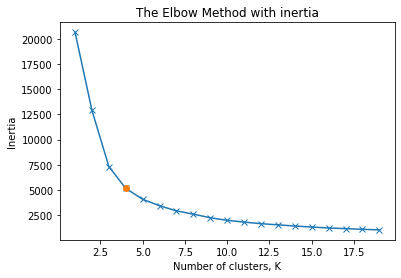

In [11]:
# Find the elbow with our function
elbow_index_of_k_mean = get_elbow_curve(inertia_list)
plot( ks , inertia_list , "-x")
plot( ks[elbow_index_of_k_mean] , inertia_list[elbow_index_of_k_mean],"-o")
title('The Elbow Method with inertia')
xlabel("Number of clusters, K")
ylabel("Inertia")
show()

In [12]:
print("The elbow method with inertia best K is ", ks[elbow_index_of_k_mean])

The elbow method with inertia best K is  4


***Get the score when maximum cluster is 20***

In [ ]:
scores = []
ks = list(range(1, 20))
for k in ks:
    kmeans = KMeans(n_clusters= k, init='random')
    kmeans.fit(X)
    scores.append(kmeans.score(X))

In [ ]:
fig, ax = subplots()
elbow_index_of_k_mean = get_elbow_curve(scores)
plot( ks[elbow_index_of_k_mean] , scores[elbow_index_of_k_mean],"-o")
xlabel("Number of clusters, k")
ylabel("Scores")
ax.plot(ks, scores, "-x")
show()

In [ ]:
print("The elbow method with scores best K is ", ks[elbow_index_of_k_mean])

***Both elbow method shows that the best K is 4***

In [ ]:
bestkmeans = KMeans(n_clusters= ks[elbow_index_of_k_mean], init='random')
bestkmeans.fit(X)

***Add a new column cluster that indicates which cluster they belong to***

In [ ]:
df["kmean_cluster"] = bestkmeans.predict(X)
df.head()

In [ ]:
fig, ax = subplots()
colors = {0:'blue', 1:'black', 2:'yellow', 3:'pink'}
ax.scatter(X[0], X[1] , c=df["kmean_cluster"].apply(lambda x: colors[x]))
show()

***Let's calculate the distance to seperate them into anomaly and non-anomaly group***

In [ ]:
# Distance between each points to the closest centroid
def getKMeansDistanceOfPoints(X, model):
    distance = Series()
    for i in range(0,len(X)):
        Xa = array(X.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        # Euclidean distance with numpy.linalg.norm
        distance.at[i] = linalg.norm(Xa-Xb)
    return distance

In [ ]:
distance = getKMeansDistanceOfPoints(X, bestkmeans)
distance.head()

***Our Outliers fraction***

In [ ]:
outliers_fraction = 0.01

In [ ]:
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

print(f"The number of outliers is {number_of_outliers}")
print(f"The threshold is {threshold}")

***If the distance is larger than threshold, it will be Anomaly (1)***

In [ ]:
df['kmean_anomaly'] = (distance >= threshold).astype(int)
df.head()

In [ ]:
fig, ax = subplots()
colors = {0:'grey', 1:'red'}
grey_patch = Patch(color='grey', label='Non-Anomaly')
red_patch = Patch(color='red', label='Anomaly')
legend(handles=[grey_patch,red_patch])
ax.scatter(X[0], X[1] , c=df["kmean_anomaly"].apply(lambda x: colors[x]))
show()

In [ ]:
number_of_anomally = len(df.loc[df['kmean_anomaly']==1])      
print(f"Percentage of kmean anomalies in data: {(number_of_anomally/len(df))*100} %")

***
# Isolation Forest

In [ ]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=outliers_fraction)
model.fit(X)

In [ ]:
df['isolation_scores'] = model.decision_function(X)
df['isolation_anomaly'] = model.predict(X)
df.head()

In [ ]:
number_of_anomally = len(df.loc[df['isolation_anomaly']==-1])      
print(f"Percentage of anomalies in data: {(number_of_anomally/len(df))*100} %")

In [ ]:
fig, ax = subplots()
colors = {1:'grey', -1:'red'}
grey_patch = Patch(color='grey', label='Non-Anomaly')
red_patch = Patch(color='red', label='Anomaly')
legend(handles=[grey_patch,red_patch])
ax.scatter(X[0], X[1] , c=df["isolation_anomaly"].apply(lambda x: colors[x]))
show()

***It looks similar to our kmeans graph :)*** <br>
***
# Find out what are the anomalies
When kmean_anomaly column is 1 and When isolation_anomaly is -1

In [ ]:
df_anomaly = df.loc[ (df["kmean_anomaly"]==1) & (df["isolation_anomaly"]==-1)]
df_anomaly.head()

***We only want the unique dates***<br>
We make the timestamp to be index and groupby them together

In [ ]:
df_temp = df_anomaly.groupby([df_anomaly['timestamp'].dt.date]).mean()
df_temp.head()

In [ ]:
df_temp.index.unique()

## FUN EXPLORATION OF ANOMALIES 
- 2014-11-02 is an anomaly because this date is the NYC Marathon, the increase of value (number of passengers is of course normal!!)
- 2014-12-31 and 2015-01-01 (New Year's Eve and New Year!) NEW YORKERS demand for taxi definitely increase 

In [ ]:
figure(figsize=(20,10))
df_anomaly.plot(kind='scatter', x="timestamp",y="value",color='red')
title("Kmean and Isolation Anomalies")
show()

# Summary
- Isolation forest and KMeans seems reliable because both of them produce a lot of similar anomally points and similar percentage of anomalies